## Prerequisites
You need to install the following libraries to run codes in this article. 

1. GridDB C Client
2. GridDB Python client

You can find the instructions for installing these clients on [GridDB Python Package Index (Pypi)](https://pypi.org/project/griddb-python/). 

You will also need to install Amazon Chronos, Numpy, Pandas, and Matplotlib libraries.

The scripts below will help you install and import the necessary libraries for running the code in this article.

In [101]:
%pip install git+https://github.com/amazon-science/chronos-forecasting.git
%pip install matplotlib seaborn numpy pandas scikit-learn

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-lqfv1m0d
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-lqfv1m0d
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit ac6ee36acee1e47446cd66f72f540c87f1f1fbe4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [102]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
import griddb_python as griddb
from sklearn.metrics import mean_absolute_error

## Inserting Time Series Data Into GriddB

### Downloading and Importing Electricity Production Data from Kaggle

In [103]:
dataset = pd.read_csv("Electric_Production.csv")
dataset.head(10)

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
5,6/1/1985,58.0904
6,7/1/1985,62.6202
7,8/1/1985,63.2485
8,9/1/1985,60.5846
9,10/1/1985,56.3154


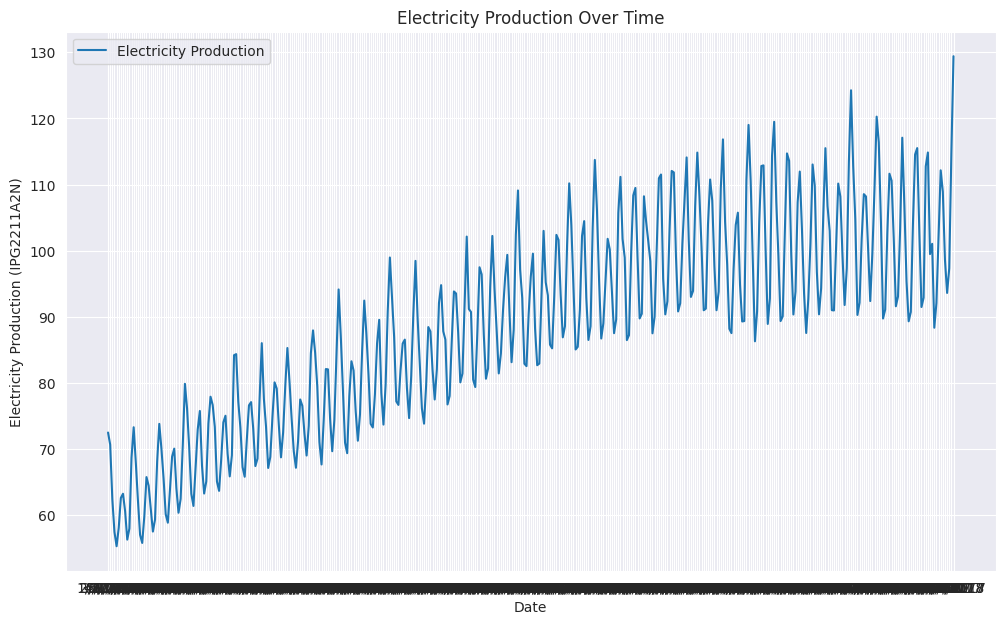

In [104]:
# Create the line plot
sns.set_style("darkgrid")
plt.figure(figsize=(12, 7))
sns.lineplot(data=dataset, x='DATE', y='IPG2211A2N', label='Electricity Production')
plt.xlabel('Date')
plt.ylabel('Electricity Production (IPG2211A2N)')
plt.title('Electricity Production Over Time')
plt.legend()

plt.show()

### Connect to GridDB

In [105]:
# GridDB connection details
DB_HOST = "127.0.0.1:10001"
DB_CLUSTER = "myCluster"
DB_USER = "admin"
DB_PASS = "admin"

# creating a connection

factory = griddb.StoreFactory.get_instance()

try:
    gridstore = factory.get_store(
        notification_member = DB_HOST,
        cluster_name = DB_CLUSTER,
        username = DB_USER,
        password = DB_PASS
    )

    container1 = gridstore.get_container("container1")
    if container1 == None:
        print("Container does not exist")
    print("Successfully connected to GridDB")

except griddb.GSException as e:
    for i in range(e.get_error_stack_size()):
        print("[", i, "]")
        print(e.get_error_code(i))
        print(e.get_location(i))
        print(e.get_message(i))

Container does not exist
Successfully connected to GridDB


### Create Container for Electricity Production Data in GridDB

In [106]:
dataset['DATE'] = pd.to_datetime(dataset['DATE'])


container_name = "Electricity_Production"
column_info = [
    ["Timestamp", griddb.Type.TIMESTAMP],
    ["Production", griddb.Type.DOUBLE]
]
container_info = griddb.ContainerInfo(container_name, column_info, griddb.ContainerType.TIME_SERIES)

# Creating Container
try:
    gridstore.put_container(container_info)
    container = gridstore.get_container(container_name)
    if container is None:
        print(f"Failed to create container: {container_name}")
    else:
        print(f"Successfully created container: {container_name}")

except griddb.GSException as e:
    print(f"Error creating or retrieving container {container_name}:")
    for i in range(e.get_error_stack_size()):
        print(f"[{i}]")
        print(f"Error code: {e.get_error_code(i)}")
        print(f"Location: {e.get_location(i)}")
        print(f"Message: {e.get_message(i)}")

Successfully created container: Electricity_Production


### Insert Electricity Production Data into GridDB Container

In [107]:
try:
    for index, row in dataset.iterrows():
        container.put([row['DATE'].to_pydatetime(), row['IPG2211A2N']])
    print(f"Successfully inserted {len(dataset)} rows of data into {container_name}")

except griddb.GSException as e:
    print(f"Error inserting data into container {container_name}:")
    for i in range(e.get_error_stack_size()):
        print(f"[{i}]")
        print(f"Error code: {e.get_error_code(i)}")
        print(f"Location: {e.get_location(i)}")
        print(f"Message: {e.get_message(i)}")

Successfully inserted 397 rows of data into Electricity_Production


## Forecasting Electricity Production using Amazon's Chronos Time Series Model

### Retrieving Data from GridDB

In [108]:
def retrieve_data_from_griddb(container_name):

    try:
        stock_data_container = gridstore.get_container(container_name)

        # Query all data from the container
        query = stock_data_container.query("select *")
        rs = query.fetch()  # Adjust the number based on your data size

        data = rs.fetch_rows()
        data .set_index("Timestamp", inplace=True)
        return data

    except griddb.GSException as e:
        print(f"Error retrieving data from GridDB: {e.get_message()}")
        return None


electric_production_data = retrieve_data_from_griddb("Electricity_Production")
electric_production_data.head()

,Production
Timestamp,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### Forecasting Electrcity Producion using Amazon Chronos Model

In [109]:
# Define the test size and calculate the split index
test_size = 47
split_index = len(electric_production_data) - test_size

# Check if the data length is shorter than the test size
if split_index < 0:
    train_production = pd.Series(dtype=float)
    test_production = electric_production_data['Production']
else:
    # Splitting the Production column into training and test sets
    train_production = electric_production_data['Production'].iloc[:split_index]
    test_production = electric_production_data['Production'].iloc[split_index:]

# Display the results
print("Training Set:")
print(train_production.shape)
print("\nTest Set:")
print(test_production.shape)

Training Set:
(350,)

Test Set:
(47,)


In [110]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

In [111]:
context = torch.tensor(train_production)
prediction_length = test_size
forecast = pipeline.predict(context, prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

/tmp/ipykernel_1115656/2753997021.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(train_production)


### Evaluating Model Performance

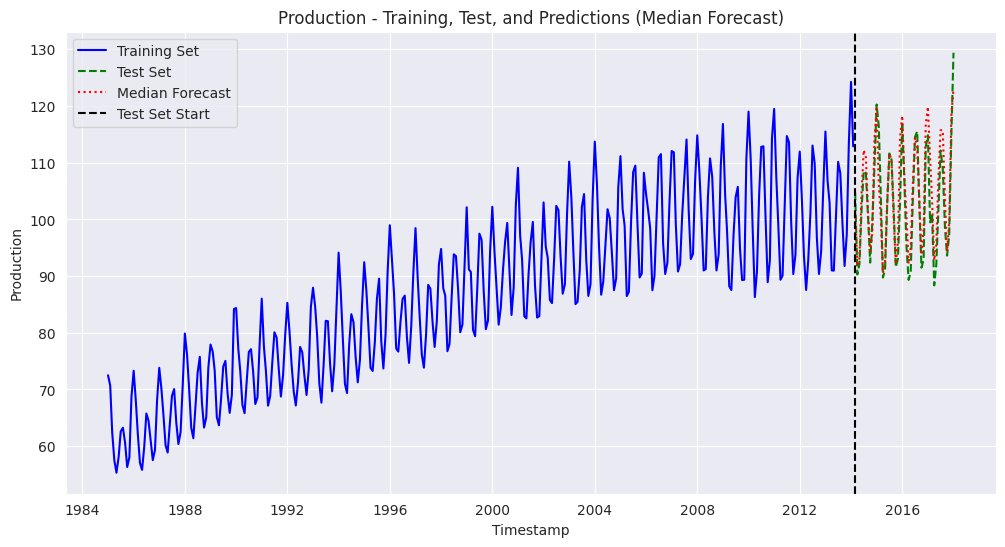

In [112]:

test_production.index = pd.to_datetime(test_production.index)
median_forecast = pd.Series(median, index=test_production.index, name="Median Forecast")

plt.figure(figsize=(12, 6))
plt.plot(train_production.index, train_production, color='blue', label="Training Set", linestyle="-")
plt.plot(test_production.index, test_production, color='green', linestyle="--", label="Test Set")
plt.plot(median_forecast.index, median_forecast, color='red', linestyle=":", label="Median Forecast")

# Vertical line to mark the start of the test set
plt.axvline(x=test_production.index[0], color='black', linestyle="--", label="Test Set Start")

plt.xlabel("Timestamp")
plt.ylabel("Production")
plt.title("Production - Training, Test, and Predictions (Median Forecast)")
plt.legend()
plt.show()


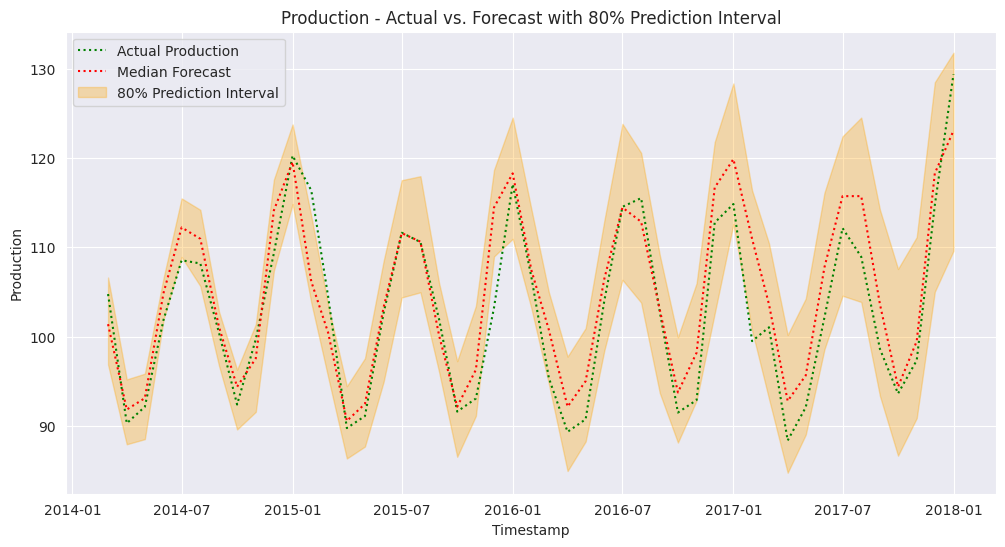

In [113]:

median_forecast = pd.Series(median, index=test_production.index, name="Median Forecast")
lower_bound = pd.Series(low, index=test_production.index, name="Lower Bound")
upper_bound = pd.Series(high, index=test_production.index, name="Upper Bound")


plt.figure(figsize=(12, 6))

plt.plot(test_production.index, test_production, color='green', linestyle=":", label="Actual Production")
plt.plot(median_forecast.index, median_forecast, color='red', linestyle=":", label="Median Forecast")

# Plot the 80% prediction interval as an orange shaded area
plt.fill_between(test_production.index, lower_bound, upper_bound, color='orange', alpha=0.3, label="80% Prediction Interval")

plt.xlabel("Timestamp")
plt.ylabel("Production")
plt.title("Production - Actual vs. Forecast with 80% Prediction Interval")
plt.legend()
plt.show()

In [114]:
mae = mean_absolute_error(test_production, median_forecast)

# Print results
print("Average electricity production values in the training set:", train_production.mean())
print("Mean Absolute Error (MAE):", mae)

Average electricity production values in the training set: 86.9775362857143
Mean Absolute Error (MAE): 3.2303302385930803
